#### We trained Convolutional Neural Network on the MNIST dataset
#### The regularization methods applied are:


*   Early Stopping
*   No Regularization
*   Dropout
*   L1 Regularization
*   L2 Regularization
*   Data Augmentation
*   Adding Noise
*   Random Weight Initialization


### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 8
batch_size = 128
learning_rate = 0.01


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 933786.27it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134331.48it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1108463.19it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7327126.45it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.max_pool(torch.relu(self.conv1(x)))
        x = self.max_pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)

### CNN without Regularization

In [5]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

train(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/8], Loss: 0.0957
Epoch [2/8], Loss: 0.0334
Epoch [3/8], Loss: 0.1511
Epoch [4/8], Loss: 0.0406
Epoch [5/8], Loss: 0.0164
Epoch [6/8], Loss: 0.0034
Epoch [7/8], Loss: 0.0042
Epoch [8/8], Loss: 0.0073


In [6]:
def evaluate(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

evaluate(model, test_loader)

Accuracy of the model on the test images: 99.07 %


### Dropout Regularization

In [7]:
class CNNWithDropout(nn.Module):
    def __init__(self):
        super(CNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.max_pool(torch.relu(self.conv1(x)))
        x = self.max_pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_dropout = CNNWithDropout().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_dropout.parameters(), lr=learning_rate, momentum=0.9)

train(model_dropout, train_loader, criterion, optimizer, num_epochs)

evaluate(model_dropout, test_loader)

Epoch [1/8], Loss: 0.1909
Epoch [2/8], Loss: 0.1168
Epoch [3/8], Loss: 0.0291
Epoch [4/8], Loss: 0.0146
Epoch [5/8], Loss: 0.1184
Epoch [6/8], Loss: 0.0051
Epoch [7/8], Loss: 0.0493
Epoch [8/8], Loss: 0.0558
Accuracy of the model on the test images: 99.09 %


### L2 Regularization

In [8]:
model_l2 = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_l2.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.01)

train(model_l2, train_loader, criterion, optimizer, num_epochs)

evaluate(model_l2, test_loader)

Epoch [1/8], Loss: 0.0936
Epoch [2/8], Loss: 0.1667
Epoch [3/8], Loss: 0.0689
Epoch [4/8], Loss: 0.0357
Epoch [5/8], Loss: 0.0821
Epoch [6/8], Loss: 0.0761
Epoch [7/8], Loss: 0.0377
Epoch [8/8], Loss: 0.0685
Accuracy of the model on the test images: 98.2 %


### Data Augmentation

In [9]:
transform_augmented = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset_augmented = torchvision.datasets.MNIST(root='./data', train=True, transform=transform_augmented, download=True)
train_loader_augmented = DataLoader(dataset=train_dataset_augmented, batch_size=batch_size, shuffle=True)

model_augmentation = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_augmentation.parameters(), lr=learning_rate, momentum=0.9)

train(model_augmentation, train_loader_augmented, criterion, optimizer, num_epochs)

evaluate(model_augmentation, test_loader)

Epoch [1/8], Loss: 0.1690
Epoch [2/8], Loss: 0.0706
Epoch [3/8], Loss: 0.0423
Epoch [4/8], Loss: 0.0835
Epoch [5/8], Loss: 0.0557
Epoch [6/8], Loss: 0.0118
Epoch [7/8], Loss: 0.0434
Epoch [8/8], Loss: 0.0300
Accuracy of the model on the test images: 99.3 %


### Early Stopping

In [10]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

model_early_stopping = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_early_stopping.parameters(), lr=learning_rate, momentum=0.9)

# # Training with early stopping
# def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=3):
#     early_stopping = EarlyStopping(patience=patience)
#     for epoch in range(num_epochs):
#         model.train()
#         for images, labels in train_loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             # Forward pass
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             # Backward and optimize
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         # Validation loss
#         model.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images = images.to(device)
#                 labels = labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item()
#         val_loss /= len(val_loader)
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

#         # Check early stopping
#         early_stopping(val_loss)
#         if early_stopping.early_stop:
#             print("Early stopping")
#             break

def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=3):
    early_stopping = EarlyStopping(patience=patience)
    train_acc = []
    val_acc = []
    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_acc.append(train_accuracy)

        # Validation loss
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_acc.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%, Val Loss: {val_loss:.4f}')

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return train_acc, val_acc

val_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

train_with_early_stopping(model_early_stopping, train_loader, val_loader, criterion, optimizer, num_epochs)

evaluate(model_early_stopping, test_loader)

Epoch [1/8], Loss: 0.0907, Train Accuracy: 91.72%, Validation Accuracy: 97.62%, Val Loss: 0.0776
Epoch [2/8], Loss: 0.0862, Train Accuracy: 97.93%, Validation Accuracy: 97.46%, Val Loss: 0.0799
Epoch [3/8], Loss: 0.0686, Train Accuracy: 98.50%, Validation Accuracy: 98.91%, Val Loss: 0.0356
Epoch [4/8], Loss: 0.0137, Train Accuracy: 98.88%, Validation Accuracy: 99.11%, Val Loss: 0.0291
Epoch [5/8], Loss: 0.0531, Train Accuracy: 99.10%, Validation Accuracy: 99.21%, Val Loss: 0.0277
Epoch [6/8], Loss: 0.0382, Train Accuracy: 99.28%, Validation Accuracy: 99.32%, Val Loss: 0.0222
Epoch [7/8], Loss: 0.0028, Train Accuracy: 99.34%, Validation Accuracy: 99.58%, Val Loss: 0.0154
Epoch [8/8], Loss: 0.0255, Train Accuracy: 99.44%, Validation Accuracy: 99.66%, Val Loss: 0.0121
Accuracy of the model on the test images: 99.14 %


In [11]:
class CNNWithNoise(nn.Module):
    def __init__(self):
        super(CNNWithNoise, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self.noise = nn.Dropout(p=0.1)

    def forward(self, x):
        x = self.noise(self.max_pool(torch.relu(self.conv1(x))))
        x = self.noise(self.max_pool(torch.relu(self.conv2(x))))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_noise = CNNWithNoise().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_noise.parameters(), lr=learning_rate, momentum=0.9)

train(model_noise, train_loader, criterion, optimizer, num_epochs)

evaluate(model_noise, test_loader)

Epoch [1/8], Loss: 0.0514
Epoch [2/8], Loss: 0.0589
Epoch [3/8], Loss: 0.0407
Epoch [4/8], Loss: 0.0402
Epoch [5/8], Loss: 0.0634
Epoch [6/8], Loss: 0.0035
Epoch [7/8], Loss: 0.0100
Epoch [8/8], Loss: 0.0205
Accuracy of the model on the test images: 99.13 %


### Random Weight Initialization

In [12]:
class CNNWithRandomInit(nn.Module):
    def __init__(self):
        super(CNNWithRandomInit, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self._initialize_weights()

    def forward(self, x):
        x = self.max_pool(torch.relu(self.conv1(x)))
        x = self.max_pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

model_random_init = CNNWithRandomInit().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_random_init.parameters(), lr=learning_rate, momentum=0.9)

train(model_random_init, train_loader, criterion, optimizer, num_epochs)

evaluate(model_random_init, test_loader)


Epoch [1/8], Loss: 0.1438
Epoch [2/8], Loss: 0.0130
Epoch [3/8], Loss: 0.0655
Epoch [4/8], Loss: 0.0496
Epoch [5/8], Loss: 0.0135
Epoch [6/8], Loss: 0.0134
Epoch [7/8], Loss: 0.0032
Epoch [8/8], Loss: 0.0258
Accuracy of the model on the test images: 98.69 %


### L1 Normalization

In [13]:
# Custom loss function with L1 regularization
class L1LossWithReg(nn.Module):
    def __init__(self, model, l1_lambda):
        super(L1LossWithReg, self).__init__()
        self.model = model
        self.l1_lambda = l1_lambda
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        l1_norm = sum(p.abs().sum() for p in self.model.parameters())
        loss = self.criterion(outputs, targets) + self.l1_lambda * l1_norm
        return loss

model_l1 = CNN().to(device)

l1_lambda = 0.01
criterion = L1LossWithReg(model_l1, l1_lambda)
optimizer = optim.SGD(model_l1.parameters(), lr=learning_rate, momentum=0.9)

train(model_l1, train_loader, criterion, optimizer, num_epochs)

evaluate(model_l1, test_loader)

Epoch [1/8], Loss: 2.5780
Epoch [2/8], Loss: 2.5776
Epoch [3/8], Loss: 2.5782
Epoch [4/8], Loss: 2.5781
Epoch [5/8], Loss: 2.5790
Epoch [6/8], Loss: 2.5781
Epoch [7/8], Loss: 2.5805
Epoch [8/8], Loss: 2.5787
Accuracy of the model on the test images: 11.35 %


### Compare

In [14]:
def train_with_logging(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_acc = []
    val_acc = []
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc.append(100 * correct / total)
        val_acc.append(evaluate(model, test_loader, logging=False))
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_acc[-1]:.2f}%, Validation Accuracy: {val_acc[-1]:.2f}%')
    return train_acc, val_acc

def evaluate(model, test_loader, logging=True):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        if logging:
            print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
        return 100 * correct / total

In [15]:
histories = []

# Early Stopping
model_early_stopping = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_early_stopping.parameters(), lr=learning_rate, momentum=0.9)
train_acc_early_stopping, val_acc_early_stopping = train_with_early_stopping(model_early_stopping, train_loader, val_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'Early Stopping', 'train_acc': train_acc_early_stopping, 'val_acc': val_acc_early_stopping})


# No regularization
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_acc, val_acc = train_with_logging(model, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'No Regularization', 'train_acc': train_acc, 'val_acc': val_acc})

# Dropout
model_dropout = CNNWithDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_dropout.parameters(), lr=learning_rate, momentum=0.9)
train_acc_dropout, val_acc_dropout = train_with_logging(model_dropout, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'Dropout', 'train_acc': train_acc_dropout, 'val_acc': val_acc_dropout})

# L2 Regularization
model_l2 = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_l2.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.01)
train_acc_l2, val_acc_l2 = train_with_logging(model_l2, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'L2 Regularization', 'train_acc': train_acc_l2, 'val_acc': val_acc_l2})

# Data Augmentation
model_augmentation = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_augmentation.parameters(), lr=learning_rate, momentum=0.9)
train_acc_augmentation, val_acc_augmentation = train_with_logging(model_augmentation, train_loader_augmented, criterion, optimizer, num_epochs)
histories.append({'label': 'Data Augmentation', 'train_acc': train_acc_augmentation, 'val_acc': val_acc_augmentation})

# # Early Stopping
# model_early_stopping = CNN().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model_early_stopping.parameters(), lr=learning_rate, momentum=0.9)
# train_acc_early_stopping, val_acc_early_stopping = train_with_early_stopping(model_early_stopping, train_loader, val_loader, criterion, optimizer, num_epochs)
# histories.append({'label': 'Early Stopping', 'train_acc': train_acc_early_stopping, 'val_acc': val_acc_early_stopping})

# Adding Noise
model_noise = CNNWithNoise().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_noise.parameters(), lr=learning_rate, momentum=0.9)
train_acc_noise, val_acc_noise = train_with_logging(model_noise, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'Adding Noise', 'train_acc': train_acc_noise, 'val_acc': val_acc_noise})

# Random Weight Initialization
model_random_init = CNNWithRandomInit().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_random_init.parameters(), lr=learning_rate, momentum=0.9)
train_acc_random_init, val_acc_random_init = train_with_logging(model_random_init, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'Random Weight Initialization', 'train_acc': train_acc_random_init, 'val_acc': val_acc_random_init})

# L1 Regularization
model_l1 = CNN().to(device)
l1_lambda = 0.01
criterion = L1LossWithReg(model_l1, l1_lambda)
optimizer = optim.SGD(model_l1.parameters(), lr=learning_rate, momentum=0.9)
train_acc_l1, val_acc_l1 = train_with_logging(model_l1, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'L1 Regularization', 'train_acc': train_acc_l1, 'val_acc': val_acc_l1})


Epoch [1/8], Loss: 0.0528, Train Accuracy: 90.67%, Validation Accuracy: 97.47%, Val Loss: 0.0852
Epoch [2/8], Loss: 0.0998, Train Accuracy: 97.81%, Validation Accuracy: 98.06%, Val Loss: 0.0611
Epoch [3/8], Loss: 0.0188, Train Accuracy: 98.44%, Validation Accuracy: 98.70%, Val Loss: 0.0409
Epoch [4/8], Loss: 0.0375, Train Accuracy: 98.80%, Validation Accuracy: 99.04%, Val Loss: 0.0306
Epoch [5/8], Loss: 0.0098, Train Accuracy: 98.98%, Validation Accuracy: 99.26%, Val Loss: 0.0242
Epoch [6/8], Loss: 0.0637, Train Accuracy: 99.22%, Validation Accuracy: 99.31%, Val Loss: 0.0213
Epoch [7/8], Loss: 0.0056, Train Accuracy: 99.34%, Validation Accuracy: 99.49%, Val Loss: 0.0160
Epoch [8/8], Loss: 0.0227, Train Accuracy: 99.40%, Validation Accuracy: 99.56%, Val Loss: 0.0148
Epoch [1/8], Loss: 0.1337, Train Accuracy: 90.89%, Validation Accuracy: 97.71%
Epoch [2/8], Loss: 0.0182, Train Accuracy: 97.92%, Validation Accuracy: 98.54%
Epoch [3/8], Loss: 0.0149, Train Accuracy: 98.57%, Validation Accu

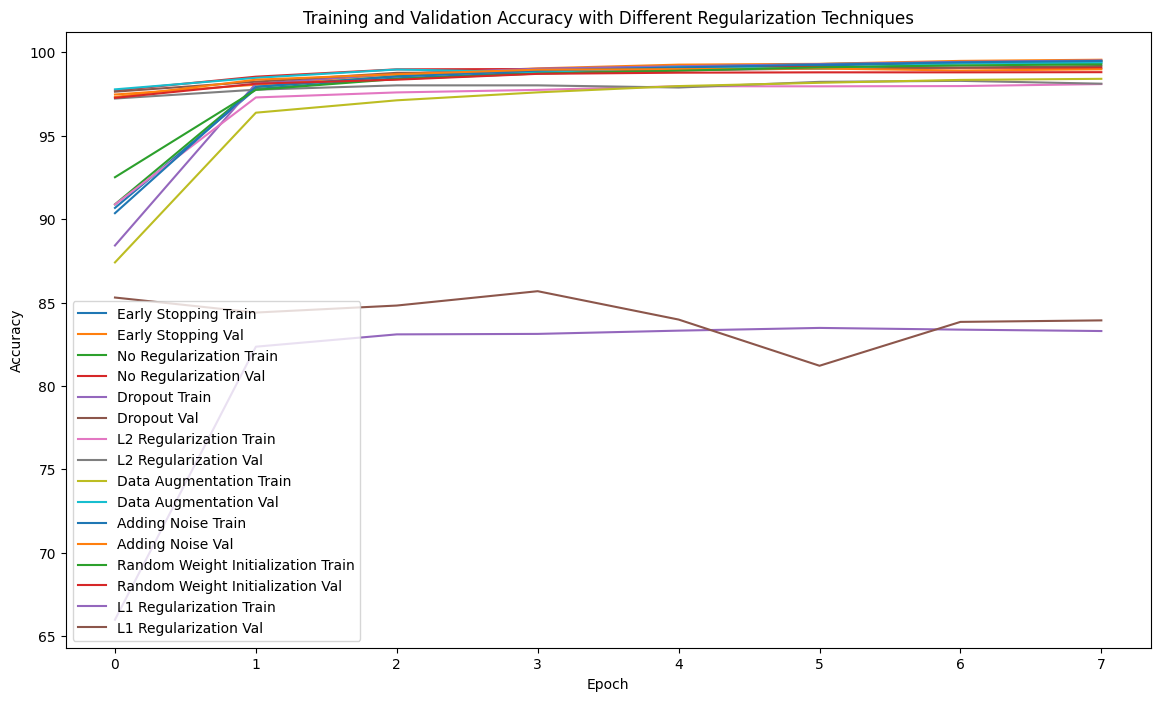

In [16]:
def plot_results(histories, title):
    plt.figure(figsize=(14, 8))
    for history in histories:
        plt.plot(history['train_acc'], label=history['label'] + ' Train')
        plt.plot(history['val_acc'], label=history['label'] + ' Val')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_results(histories, 'Training and Validation Accuracy with Different Regularization Techniques')


In [17]:
def train_with_logging(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_acc = []
    val_acc = []
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        val_loss, val_accuracy = evaluate(model, test_loader)
        val_losses.append(val_loss)
        val_acc.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_acc[-1]:.2f}%, Validation Accuracy: {val_acc[-1]:.2f}%')

    return train_acc, val_acc, train_losses, val_losses

def evaluate(model, test_loader, logging=True):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    if logging:
        print('Accuracy of the model on the test images: {} %'.format(accuracy))
    return val_loss / len(test_loader), accuracy


def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=3):
    early_stopping = EarlyStopping(patience=patience)
    train_acc = []
    val_acc = []
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_acc.append(100 * correct / total)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_acc[-1]:.2f}%, Validation Accuracy: {val_acc[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}')

        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return train_acc, val_acc, train_losses, val_losses


In [18]:
histories = []

# Early Stopping
model_early_stopping = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_early_stopping.parameters(), lr=learning_rate, momentum=0.9)
train_acc_early_stopping, val_acc_early_stopping, train_losses_early_stopping, val_losses_early_stopping = train_with_early_stopping(model_early_stopping, train_loader, val_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'Early Stopping', 'train_acc': train_acc_early_stopping, 'val_acc': val_acc_early_stopping, 'train_losses': train_losses_early_stopping, 'val_losses': val_losses_early_stopping})


# No regularization
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_acc, val_acc, train_losses, val_losses = train_with_logging(model, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'No Regularization', 'train_acc': train_acc, 'val_acc': val_acc, 'train_losses': train_losses, 'val_losses': val_losses})

# Dropout
model_dropout = CNNWithDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_dropout.parameters(), lr=learning_rate, momentum=0.9)
train_acc_dropout, val_acc_dropout, train_losses_dropout, val_losses_dropout = train_with_logging(model_dropout, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'Dropout', 'train_acc': train_acc_dropout, 'val_acc': val_acc_dropout, 'train_losses': train_losses_dropout, 'val_losses': val_losses_dropout})

# L2 Regularization
model_l2 = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_l2.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.01)
train_acc_l2, val_acc_l2, train_losses_l2, val_losses_l2 = train_with_logging(model_l2, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'L2 Regularization', 'train_acc': train_acc_l2, 'val_acc': val_acc_l2, 'train_losses': train_losses_l2, 'val_losses': val_losses_l2})

# Data Augmentation
model_augmentation = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_augmentation.parameters(), lr=learning_rate, momentum=0.9)
train_acc_augmentation, val_acc_augmentation, train_losses_augmentation, val_losses_augmentation = train_with_logging(model_augmentation, train_loader_augmented, criterion, optimizer, num_epochs)
histories.append({'label': 'Data Augmentation', 'train_acc': train_acc_augmentation, 'val_acc': val_acc_augmentation, 'train_losses': train_losses_augmentation, 'val_losses': val_losses_augmentation})

# # Early Stopping
# model_early_stopping = CNN().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model_early_stopping.parameters(), lr=learning_rate, momentum=0.9)
# train_acc_early_stopping, val_acc_early_stopping, train_losses_early_stopping, val_losses_early_stopping = train_with_early_stopping(model_early_stopping, train_loader, val_loader, criterion, optimizer, num_epochs)
# histories.append({'label': 'Early Stopping', 'train_acc': train_acc_early_stopping, 'val_acc': val_acc_early_stopping, 'train_losses': train_losses_early_stopping, 'val_losses': val_losses_early_stopping})

# Adding Noise
model_noise = CNNWithNoise().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_noise.parameters(), lr=learning_rate, momentum=0.9)
train_acc_noise, val_acc_noise, train_losses_noise, val_losses_noise = train_with_logging(model_noise, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'Adding Noise', 'train_acc': train_acc_noise, 'val_acc': val_acc_noise, 'train_losses': train_losses_noise, 'val_losses': val_losses_noise})

# Random Weight Initialization
model_random_init = CNNWithRandomInit().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_random_init.parameters(), lr=learning_rate, momentum=0.9)
train_acc_random_init, val_acc_random_init, train_losses_random_init, val_losses_random_init = train_with_logging(model_random_init, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'Random Weight Initialization', 'train_acc': train_acc_random_init, 'val_acc': val_acc_random_init, 'train_losses': train_losses_random_init, 'val_losses': val_losses_random_init})

# L1 Regularization
model_l1 = CNN().to(device)
l1_lambda = 0.01
criterion = L1LossWithReg(model_l1, l1_lambda)
optimizer = optim.SGD(model_l1.parameters(), lr=learning_rate, momentum=0.9)
train_acc_l1, val_acc_l1, train_losses_l1, val_losses_l1 = train_with_logging(model_l1, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'L1 Regularization', 'train_acc': train_acc_l1, 'val_acc': val_acc_l1, 'train_losses': train_losses_l1, 'val_losses': val_losses_l1})


Epoch [1/8], Loss: 0.0679, Train Accuracy: 91.78%, Validation Accuracy: 97.21%, Val Loss: 0.0884
Epoch [2/8], Loss: 0.0446, Train Accuracy: 97.86%, Validation Accuracy: 98.47%, Val Loss: 0.0496
Epoch [3/8], Loss: 0.0503, Train Accuracy: 98.51%, Validation Accuracy: 98.77%, Val Loss: 0.0393
Epoch [4/8], Loss: 0.0954, Train Accuracy: 98.83%, Validation Accuracy: 99.00%, Val Loss: 0.0318
Epoch [5/8], Loss: 0.0065, Train Accuracy: 99.01%, Validation Accuracy: 99.33%, Val Loss: 0.0221
Epoch [6/8], Loss: 0.0230, Train Accuracy: 99.19%, Validation Accuracy: 99.19%, Val Loss: 0.0245
Epoch [7/8], Loss: 0.0189, Train Accuracy: 99.33%, Validation Accuracy: 99.55%, Val Loss: 0.0151
Epoch [8/8], Loss: 0.0343, Train Accuracy: 99.46%, Validation Accuracy: 99.62%, Val Loss: 0.0126
Accuracy of the model on the test images: 97.67 %
Epoch [1/8], Loss: 0.0423, Train Accuracy: 91.16%, Validation Accuracy: 97.67%
Accuracy of the model on the test images: 98.46 %
Epoch [2/8], Loss: 0.0292, Train Accuracy: 97

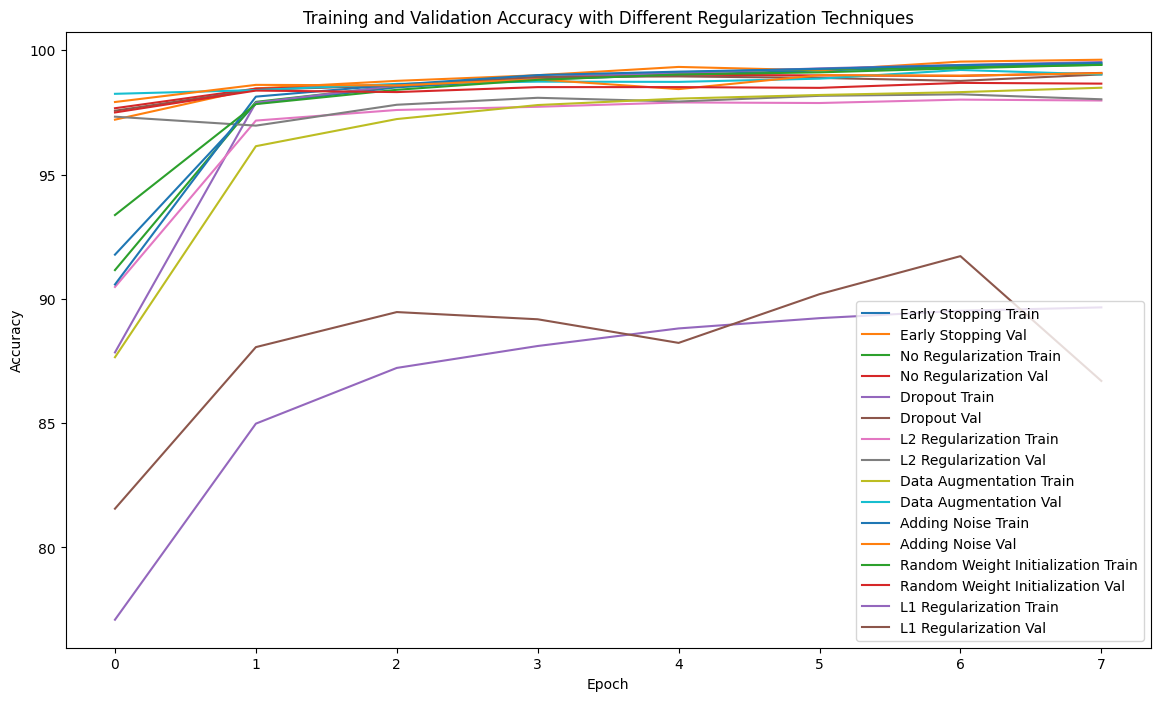

In [19]:
import matplotlib.pyplot as plt

def plot_accuracy(histories, title):
    plt.figure(figsize=(14, 8))
    for history in histories:
        plt.plot(history['train_acc'], label=history['label'] + ' Train')
        plt.plot(history['val_acc'], label=history['label'] + ' Val')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



# Plot accuracy
plot_accuracy(histories, 'Training and Validation Accuracy with Different Regularization Techniques')


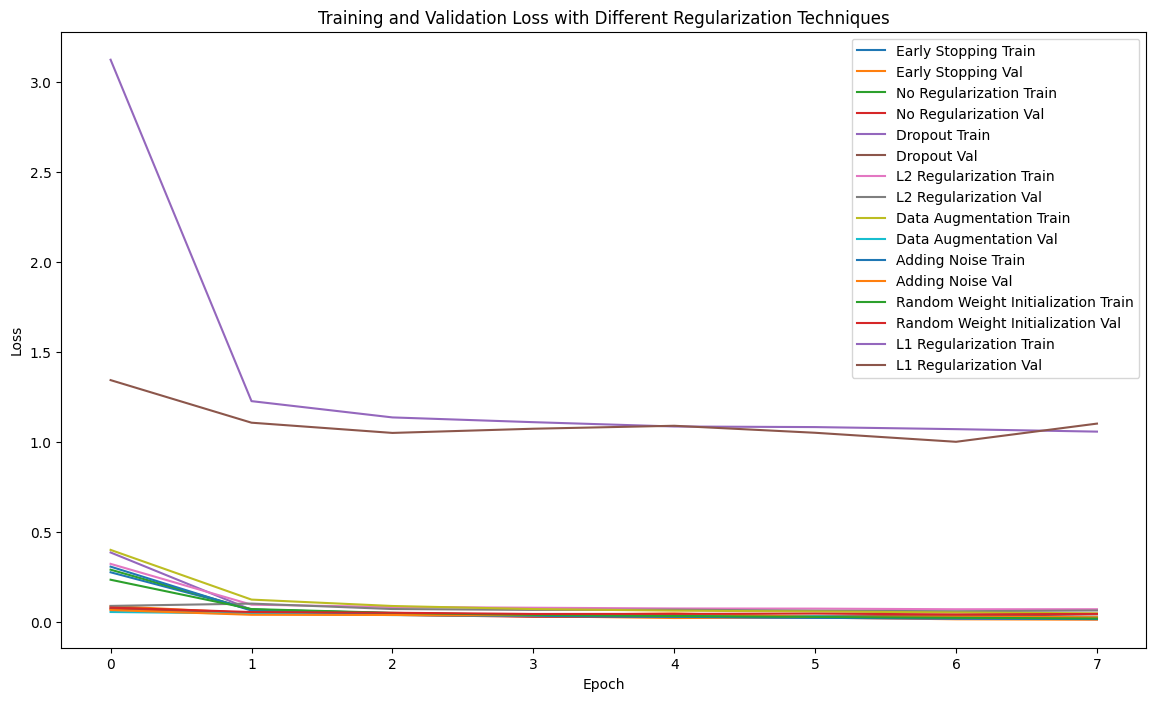

In [20]:
def plot_loss(histories, title):
    plt.figure(figsize=(14, 8))
    for history in histories:
        plt.plot(history['train_losses'], label=history['label'] + ' Train')
        plt.plot(history['val_losses'], label=history['label'] + ' Val')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Plot loss
plot_loss(histories, 'Training and Validation Loss with Different Regularization Techniques')

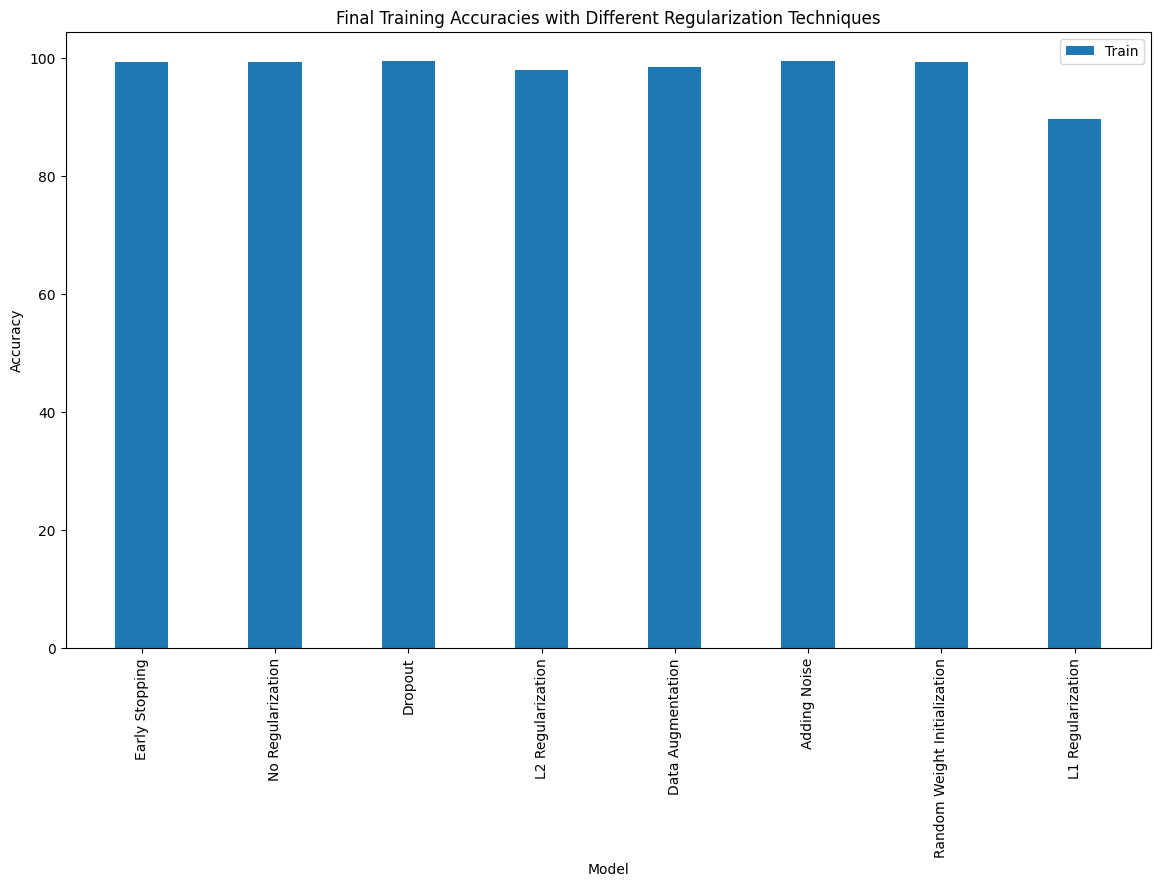

In [21]:
# def plot_final_accuracies(histories, title):
#     labels = [history['label'] for history in histories]
#     train_accuracies = [history['train_acc'][-1] for history in histories]
#     val_accuracies = [history['val_acc'][-1] for history in histories]

#     x = range(len(labels))

#     plt.figure(figsize=(14, 8))
#     plt.bar(x, train_accuracies, width=0.4, label='Train')
#     plt.bar(x, val_accuracies, width=0.4, label='Validation', bottom=train_accuracies)

#     plt.title(title)
#     plt.xlabel('Model')
#     plt.ylabel('Accuracy')
#     plt.xticks(x, labels, rotation='vertical')
#     plt.legend()
#     plt.show()

# # Plot final accuracies
# plot_final_accuracies(histories, 'Final Training and Validation Accuracies with Different Regularization Techniques')

import matplotlib.pyplot as plt

def plot_final_train_accuracies(histories, title):
    labels = [history['label'] for history in histories]
    train_accuracies = [history['train_acc'][-1] for history in histories]

    x = range(len(labels))

    plt.figure(figsize=(14, 8))
    plt.bar(x, train_accuracies, width=0.4, label='Train')

    plt.title(title)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(x, labels, rotation='vertical')
    plt.legend()
    plt.show()

# Plot final training accuracies
plot_final_train_accuracies(histories, 'Final Training Accuracies with Different Regularization Techniques')



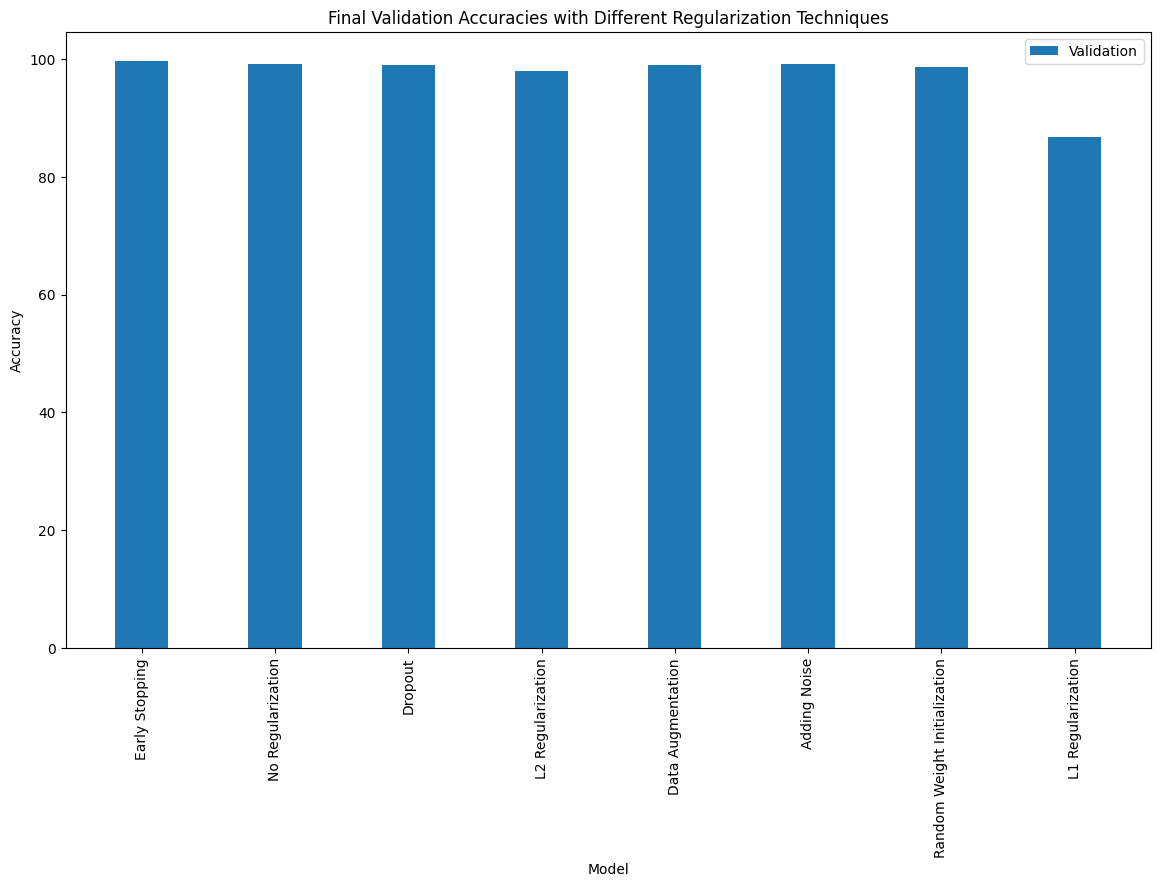

In [22]:
def plot_final_val_accuracies(histories, title):
    labels = [history['label'] for history in histories]
    val_accuracies = [history['val_acc'][-1] for history in histories]

    x = range(len(labels))

    plt.figure(figsize=(14, 8))
    plt.bar(x, val_accuracies, width=0.4, label='Validation')

    plt.title(title)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(x, labels, rotation='vertical')
    plt.legend()
    plt.show()

# Plot final validation accuracies
plot_final_val_accuracies(histories, 'Final Validation Accuracies with Different Regularization Techniques')

#### Best Performer: Early Stopping
* Final Validation Accuracy: 99.62%
* Test Accuracy: 97.67%


#### Low Performer: L1 Regularization
* Final Validation Accuracy: 86.70%
* Test Accuracy: 91.72%



####  Early Stopping, Dropout, Adding Noise, and Random Weight Initialization generally performed well, showing high validation accuracies above 98%, which generally translated to strong test accuracies as well.

#### No Regularization and Data Augmentation showed moderate performance improvements, while L2 Regularization also shows effective control of overfitting.

#### L1 Regularization displayed lower validation and test accuracies, indicating it might not have been suitable for this dataset